##### Master Degree in Computer Science and Data Science for Economics

# Word2Vec
## A toy example and from scratch implementation

### Alfio Ferrara

For the details about the model, see [wordvec.py](./nlp/wordvec.py)

## A simple toy dataset
Let's take a simple example with pseudo docs representing different weather conditions

In [44]:
import json

In [45]:
with open('../data/weather.json', 'r') as file_in:
    data = json.load(file_in)
weather = data['weather']
for doc in weather:
    print(" | ".join(doc))

mountains | snow | ice | peak | woods | cold
beach | sand | sea | wave | sun | hot
desert | dune | cactus | sand | sun | arid
forest | tree | leaf | animal | rain | humidity
river | water | fish | spring | current | bank
sky | cloud | wind | rain | thunder | rainbow


## Create SkipGram dataloader

In [46]:
import nlp.wordbags as wb
import pandas as pd
import torch 

In [47]:
bow = wb.Bow(corpus=weather)
data_loader, inputs, outputs = bow.one_hot_skip_gram_dataloader(window=2, batch=2)

In [48]:
readable_input = pd.DataFrame(inputs, columns=bow.vocabulary)
readable_input.iloc[0].head()

mountains    1.0
snow         0.0
ice          0.0
peak         0.0
woods        0.0
Name: 0, dtype: float32

In [49]:
readable_target = pd.DataFrame(outputs, columns=bow.vocabulary)
readable_target.iloc[0].head()

mountains    0.0
snow         1.0
ice          1.0
peak         0.0
woods        0.0
Name: 0, dtype: float32

In [50]:
for x, y in data_loader:
    print(f"Input: {x}")
    print(f"Target: {y}")
    break 

Input: tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Target: tensor([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [51]:
for i, (x, y) in enumerate(data_loader):
    for batch_i in range(x.shape[0]):
        x_indices = torch.where(x[batch_i] == 1)[0].numpy()
        y_indices = torch.where(y[batch_i] == 1)[0].numpy()
        input_word = f"{[bow.idx2word[w_x] for w_x in x_indices]}"
        target_word = f"{[bow.idx2word[w_y] for w_y in y_indices]}"
        print(f"{input_word} ==> {target_word}")
    if i > 5:
        break 

['mountains'] ==> ['snow', 'ice']
['snow'] ==> ['mountains', 'ice', 'peak']
['ice'] ==> ['mountains', 'snow', 'peak', 'woods']
['peak'] ==> ['snow', 'ice', 'woods', 'cold']
['woods'] ==> ['ice', 'peak', 'cold']
['cold'] ==> ['peak', 'woods']
['beach'] ==> ['sand', 'sea']
['sand'] ==> ['beach', 'sea', 'wave']
['sea'] ==> ['beach', 'sand', 'wave', 'sun']
['wave'] ==> ['sand', 'sea', 'sun', 'hot']
['sun'] ==> ['sea', 'wave', 'hot']
['hot'] ==> ['wave', 'sun']
['desert'] ==> ['dune', 'cactus']
['dune'] ==> ['sand', 'desert', 'cactus']


## Build and train a predictor

In [52]:
from nlp.wordvec import Word2WordPrediction, Word2VecModel
from nlp.w2w_readers import WordEmbeddings

In [53]:
w2w = Word2WordPrediction(input_dim=bow.size, hidden_dim=4)
epochs = 150
learning_rate = 0.01
history = w2w.train(data_loader=data_loader, epochs=epochs, 
                    learning_rate=learning_rate)
print(history[0], history[-1])

100%|██████████| 150/150 [00:00<00:00, 366.87it/s]

10.48950327767266 9.70986082818773


### Predict next word

In [54]:
model = WordEmbeddings(words=bow, model=w2w)

In [55]:
model['desert']

array([ 1.5997185, -2.1338356, -1.3958722, -2.271472 ], dtype=float32)

In [56]:
query = 'snow'
next_word = model.predict(query, topk=10)
next_word

ice          9.981475e-01
mountains    9.735819e-04
snow         4.318188e-04
cold         4.316590e-04
peak         3.201229e-06
sun          2.966738e-06
wave         2.496231e-06
water        8.450220e-07
dune         7.918188e-07
woods        7.721055e-07
dtype: float32

### Generate text

In [57]:
import numpy as np 

In [58]:
start = "desert"
text = [start]
for i in range(6):
    p = model.predict(start)
    next_word = np.random.choice(p.index.values, p=p.values / p.values.sum())
    text.append(next_word)
    start = next_word

print(" ".join(text))

desert dune sand wave sand wave sand


## Word Embeddings

In [59]:
search = 'snow'

In [60]:
model[search]

array([-1.4383348 , -0.50341004,  1.7000929 , -2.3086178 ], dtype=float32)

### Most similar

In [61]:
model.most_similar(search, topk=10)

snow         1.000000
mountains    0.951308
peak         0.639157
woods        0.633764
ice          0.597240
hot          0.323088
spring       0.197135
sand         0.188101
river        0.177963
sea          0.164817
Name: snow, dtype: float32

### Visual map

In [62]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-dark-palette')

In [63]:
tsne = TSNE(n_components=2)
vectors = model.vectors(bow.vocabulary)
v2d = tsne.fit_transform(vectors)

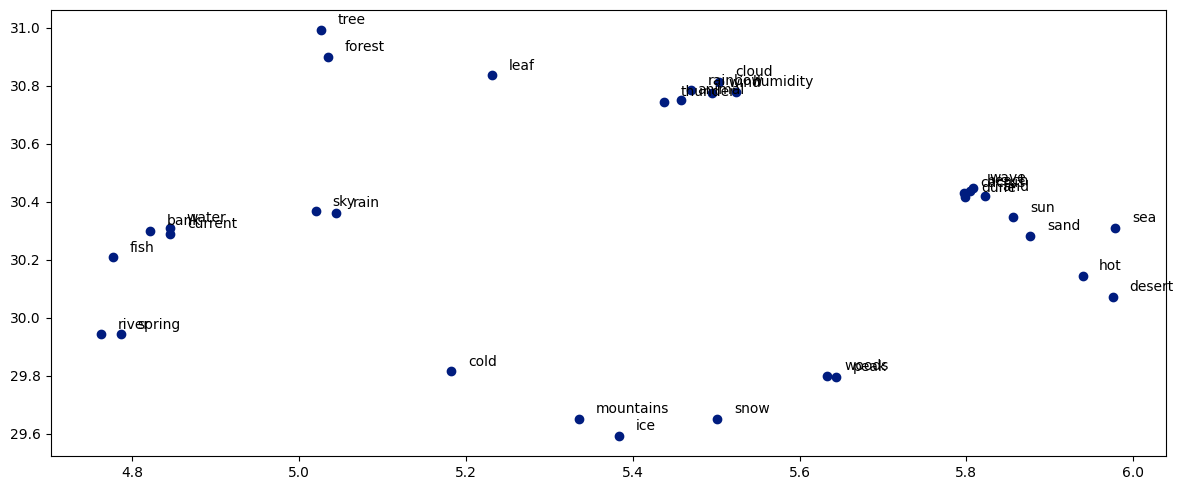

In [65]:
selected_words = bow.vocabulary
indexes = [bow.word2idx[w] for w in selected_words]
selected2d = v2d[indexes]

fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(selected2d[:,0], selected2d[:, 1])
for i, w in enumerate(selected_words):
    ax.text(selected2d[i][0] + .02, selected2d[i][1] + .02, w)
plt.tight_layout()
plt.show()

### Clustering

In [70]:
from sklearn.cluster import AffinityPropagation
from collections import defaultdict
import seaborn as sns

In [67]:
ap = AffinityPropagation()
assignments = ap.fit_predict(selected2d)
clusters = defaultdict(list)
for i, cluster in enumerate(assignments):
    clusters[cluster].append(selected_words[i])

/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [68]:
for cluster, words in clusters.items():
    print(f"Cluster {cluster}: {', '.join(words)}")

Cluster 0: mountains, snow, ice, peak, woods, cold
Cluster 1: beach, sand, sea, wave, sun, hot, desert, dune, cactus, arid
Cluster 3: forest, tree, leaf, animal, humidity, cloud, wind, thunder, rainbow
Cluster 2: rain, river, water, fish, spring, current, bank, sky


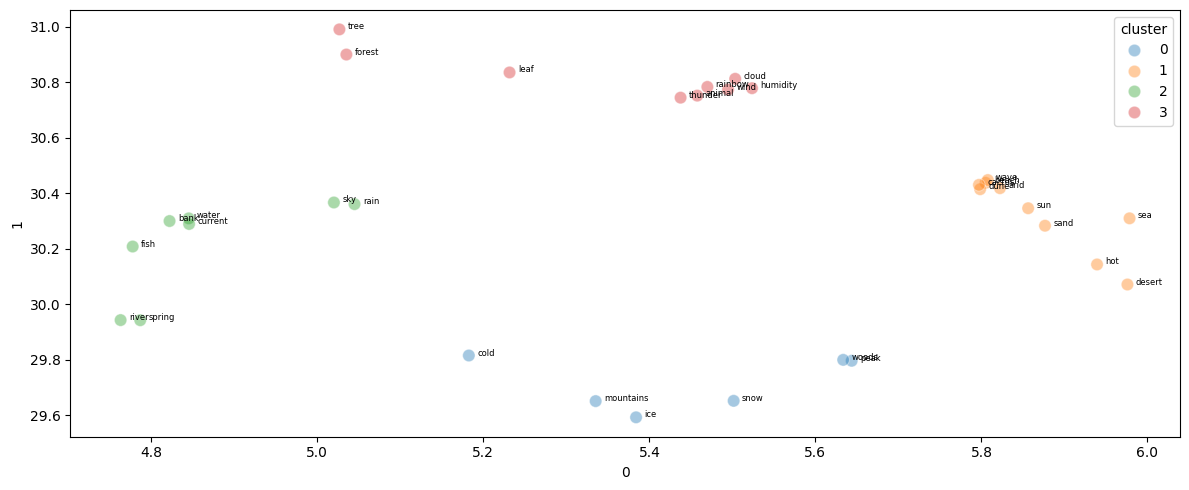

In [78]:
dfsample = pd.DataFrame(selected2d)
dfsample['word'] = selected_words
dfsample['cluster'] = assignments


fig, ax = plt.subplots(figsize=(12, 5))
scatter = sns.scatterplot(
    data=dfsample,
    x=0,
    y=1,
    hue="cluster",
    s=80,
    palette="tab10",
    legend="full",
    ax=ax,
    alpha=0.4
)
for i in range(len(dfsample)):
    plt.text(dfsample[0][i] + 0.01, dfsample[1][i], dfsample.word[i], fontsize=6)
plt.tight_layout()
plt.show()

### Directions

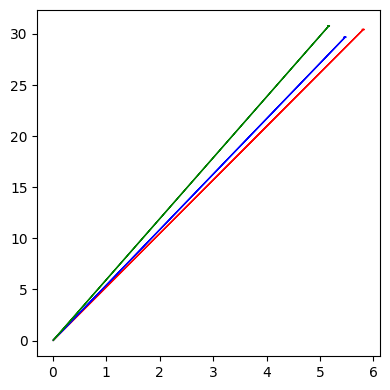

In [79]:
def pointer(group, vectors):
    g = vectors[[bow.word2idx[w] for w in group]]
    return g.mean(axis=0)

group1 = ['dune', 'beach', 'cactus', 'arid']
group2 = ['snow', 'peak', 'mountains', 'ice']
group3 = ['forest', 'tree', 'rain', 'humidity']
g1 = pointer(group1, v2d)
g2 = pointer(group2, v2d)
g3 = pointer(group3, v2d)

fig, ax = plt.subplots(figsize=(4, 4))
ax.arrow(0, 0, g1[0], g1[1], head_width=0.05, head_length=0.05, fc='red', ec='red')
ax.arrow(0, 0, g2[0], g2[1], head_width=0.05, head_length=0.05, fc='blue', ec='blue')
ax.arrow(0, 0, g3[0], g3[1], head_width=0.05, head_length=0.05, fc='green', ec='green')
plt.tight_layout()
plt.show()

## Compositionality

In [80]:
model.search(positive=['desert'], negative=['dune'])

ice        0.815595
desert     0.785126
tree       0.480704
forest     0.424127
current    0.339083
water      0.334556
bank       0.301408
river      0.255687
sand       0.249882
leaf       0.246754
dtype: float32

In [81]:
answer, a_vector = model.analogy('sea', 'wave', 'desert')
print(answer)

desert


In [82]:
model.common_meanings(['sea', 'wave', 'desert', 'sand'])

sea       0.864557
sand      0.837144
sun       0.813970
cactus    0.761680
wave      0.754710
arid      0.743772
beach     0.736226
dune      0.711926
desert    0.708149
hot       0.680727
dtype: float32

In [83]:
model.spot_odd_one(words=['mountains', 'peak', 'snow', 'sand'])

sand         0.324577
peak         0.800271
mountains    0.853041
snow         0.953163
dtype: float32

In [84]:
model.search(positive=['sea'], negative=['wave'])

hot          0.894703
sand         0.794419
sea          0.615217
ice          0.580217
forest       0.571776
cold         0.472112
snow         0.467531
peak         0.318645
woods        0.294215
mountains    0.237444
dtype: float32

In [85]:
model.search(positive=['dune', 'sea'], negative=['wave'])

sea       0.996244
sun       0.887281
hot       0.883868
sand      0.827786
arid      0.739331
wave      0.734820
cactus    0.734778
beach     0.709473
dune      0.693254
peak      0.457166
dtype: float32